In [1]:
import cv2
import numpy as np
import os
import pandas
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.optimizers import rmsprop
import keras.optimizers as optimizers
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.utils import layer_utils
import keras.backend as K
import keras
import keras_resnet.models

Using TensorFlow backend.


In [2]:
def read_images(filenames,directory,height,width):
    # Read Images into a Numpy array
    
    # Get the array size
    array_size = len(filenames)
    images = np.array([])
    #Preallocate the array.  This is much faster that numpy.append
    images = np.zeros((array_size,height,width,3))

    i=0
    for file in filenames:
        image = cv2.imread(directory + "/" + file,1)
        # Resize the image.
        resized_image = cv2.resize(image, (width,height))
        # Scale and add it to numpy array
        #print(image.shape,resized_image.shape)
        images[i] = resized_image
        i+=1

    
    
    return images

In [3]:
def get_labels(filelist,labels):
    
    labels.index = labels['Image']
    select_labels = np.array([])
    labels_filenames = []
    for file in filelist:
        select_labels = np.append(select_labels,labels.loc[file]['Encoded_Id'])
        labels_filenames.append(file)
    
    return select_labels,labels_filenames

In [4]:
def encode_labels(labels_df):

    labels = labels_df['Id'].values
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels_encode = le.transform(labels)
    
    labels_df['Encoded_Id'] = labels_encode 
    
    return labels_df

In [5]:
width = 128
height = 128

traindir="/home/james/Kaggle/Whale/Data/train"
labelsfile="/home/james/Kaggle/Whale/Data/train.csv"

In [6]:
labels = pandas.read_csv(labelsfile)
labels.describe()
#with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(labels['Id'].value_counts())
    
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 24, 10  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

labels_count = labels['Id'].value_counts()
labels_count = labels_count[:10,]

plt.bar(labels_count.index, labels_count.values, alpha=0.8)
plt.title('Top 10 Features and distribution')
plt.show()

In [7]:

labels = pandas.read_csv(labelsfile)

y=labels['Id']
values = np.array(y)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(values),
                                                 values)

print(class_weights)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_labels = onehot_encoded


[5.24330802e-04 5.06713287e+00 5.06713287e+00 ... 5.06713287e+00
 5.06713287e+00 5.06713287e+00]


In [8]:
#Get List of Directories
directories1 = os.listdir(traindir)  

directories = []
for i in range(20):
    directories = directories + directories1
    


In [10]:
input_shape = (height,width,3)

shape, classes = input_shape, 5005

def build_model(lr, l2, activation='sigmoid'):
    ##############
    # BRANCH MODEL
    ##############
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    for _ in range(4):
        x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

    ############
    # HEAD MODEL
    ############
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


model, branch_model, head_model = build_model(64e-5, 0)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

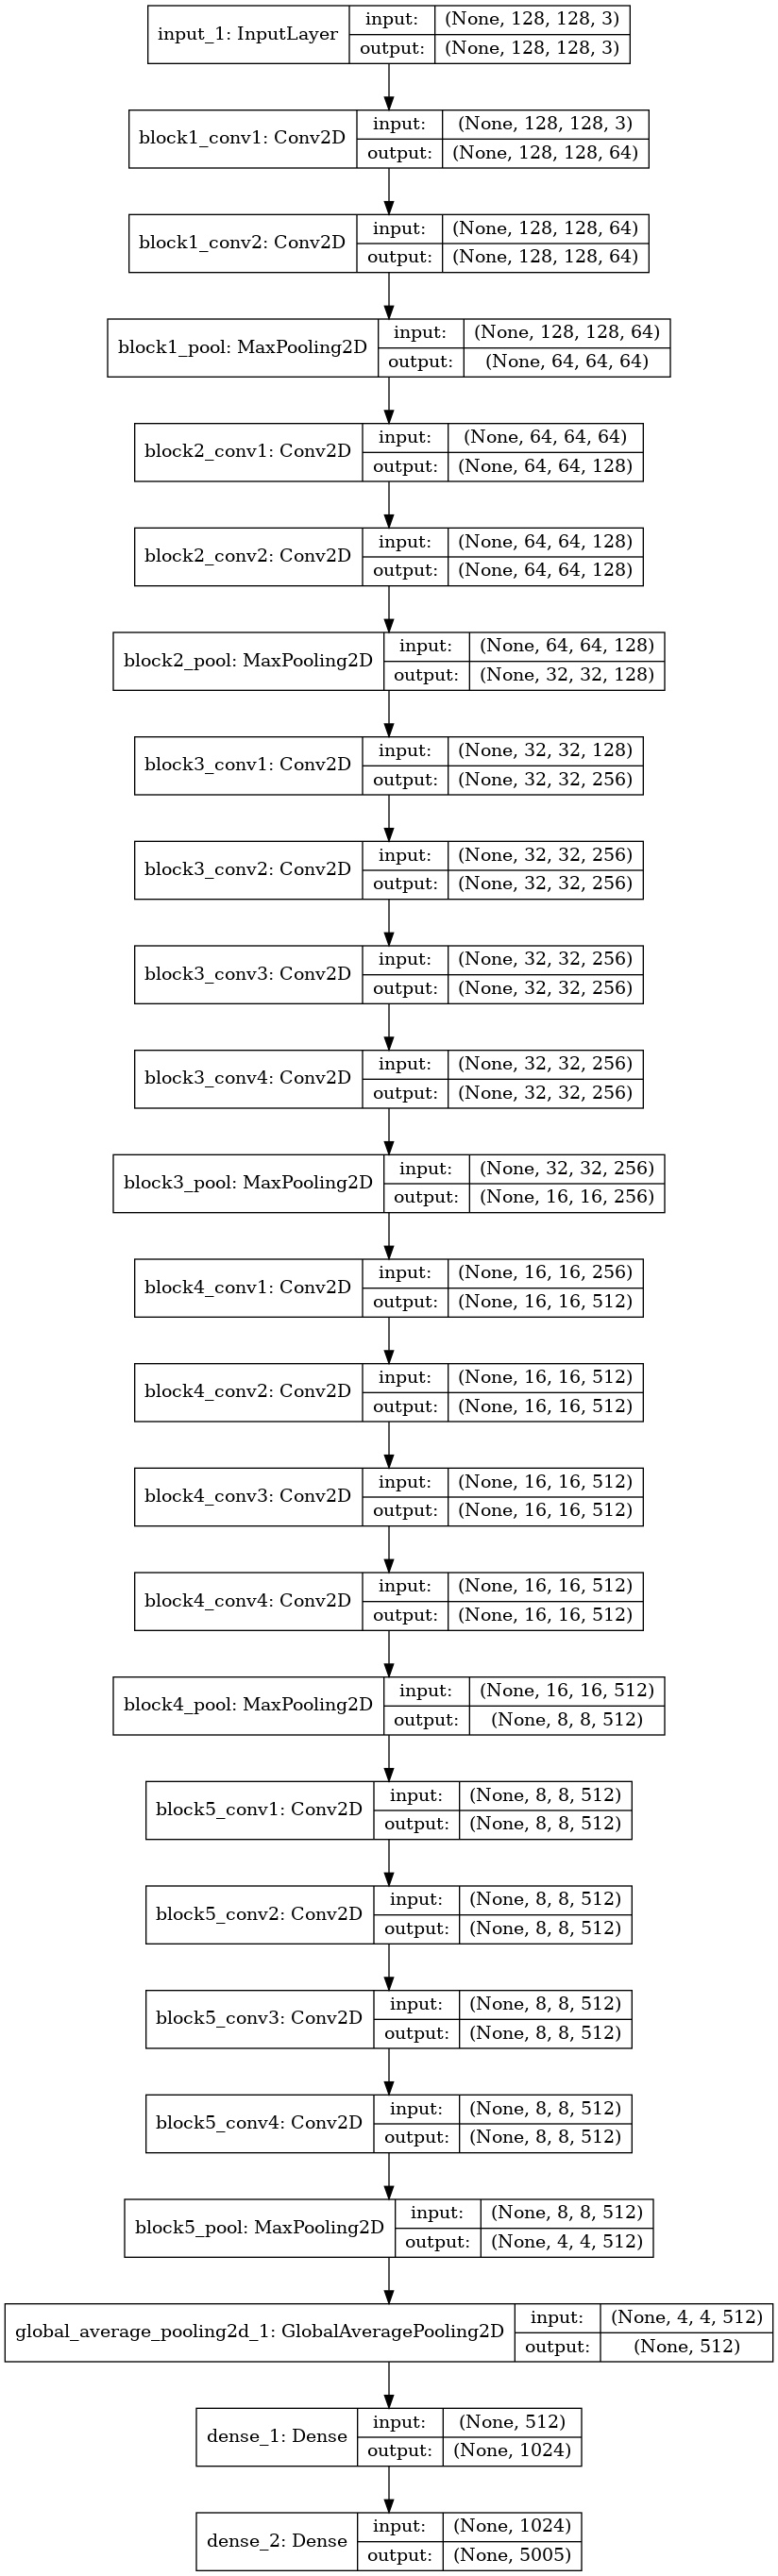

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='vgg16model.png')
from IPython.display import Image
Image(retina=True, filename='vgg16model.png')

In [15]:
#Save Models
filepath="/home/james/Kaggle/Whale/Data/whales-vgg19-adam" + ".best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor="acc",
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


callbacks_list = [checkpoint]


In [13]:
directory="masked_img"

filenames = os.listdir(traindir+"/" + directory)
filenames.sort()

chunk_images = read_images(filenames,traindir + "/" + directory,height,width)
print(chunk_images.shape)

(25361, 128, 128, 3)


In [16]:
#model.load_weights(filepath)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    featurewise_center=True, 
    featurewise_std_normalization=True
    )

datagen.fit(chunk_images)

history = model.fit_generator(
                    datagen.flow(chunk_images, train_labels, batch_size=10),
                    steps_per_epoch=len(chunk_images)/10, 
                    epochs=1500,
                    class_weight=class_weights,
                    callbacks=callbacks_list,
                    #initial_epoch=24
                    )

Epoch 1/1500
2537/2536 [==============================] - 361s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00001: acc improved from -inf to 0.38106, saving model to /home/james/Kaggle/Whale/Data/whales-vgg19-adam.best.hdf5
Epoch 2/1500
2537/2536 [==============================] - 359s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00002: acc did not improve from 0.38106
Epoch 3/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00003: acc did not improve from 0.38106
Epoch 4/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00004: acc did not improve from 0.38106
Epoch 5/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00005: acc did not improve from 0.38106
Epoch 6/1500
2537/2536 [==============================] - 361s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00006: acc did not improve from 0.38106


2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00053: acc did not improve from 0.38106
Epoch 54/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00054: acc did not improve from 0.38106
Epoch 55/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00055: acc did not improve from 0.38106
Epoch 56/1500
2537/2536 [==============================] - 360s 142ms/step - loss: 1.1921e-07 - acc: 0.3809

Epoch 00056: acc did not improve from 0.38106
Epoch 57/1500
2537/2536 [==============================] - 359s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00057: acc did not improve from 0.38106
Epoch 58/1500
2537/2536 [==============================] - 359s 142ms/step - loss: 1.1921e-07 - acc: 0.3813

Epoch 00058: acc did not improve from 0.38106
Epoch 59/1500
2537/2536 [==============================] - 359s 142ms/step - loss: 1

KeyboardInterrupt: 

In [ ]:
testdir = "/home/james/Kaggle/Whale/Data/test/masked_img"
testfilenames = os.listdir(testdir)
testfilenames.sort()


test_images = read_images(testfilenames,testdir,height,width)
# Reshape Array
#test_images = test_images.reshape((test_images.shape[0],height,width,1))


In [18]:
model.load_weights(filepath)
# Make prediction
Predictions = model.predict(test_images)

In [19]:
test_csv = "/home/james/Kaggle/Whale/Data/test.csv"

test = testfilenames
col = ['Image']
test_df = pandas.DataFrame(test, columns=col)
test_df['Id'] = ''

for i, pred in enumerate(Predictions):
    ids = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
    ids = ids.tolist()
    sorted_idx = pred.argsort()[-5:][::-1]
    sorted_values = []
    for idx in sorted_idx:
        sorted_values.append(pred[idx])

    print(sorted_values)
    if sorted_values[0] < .50:
        ids.pop(-1)
        ids.insert(0,'new_whale')
    
    test_df.loc[i, 'Id'] = ' '.join(ids)

print(test_df.head(10))

test_df.to_csv(test_csv, index=False)

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99165195, 0.008348054, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999969, 3.0894944e-06, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 9.646142e-33, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9273633, 0.0726367, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.872952e-33, 0.0, 0.0, 0.0]
[1.0, 7.318432e-12, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.885941e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.172098e-28, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9951703, 0.004829722, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999166, 8.398072e-06, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.2425973e-14, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.480715e-09, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.1170528e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99992275, 7.7221914e-05, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.138345e-13, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.2208438e-24, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999726, 2.72647e-06, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.6853228e-23, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.1386312e-20, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.7535

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

In [ ]:
# Reference
#https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py